# Data analysis with SciAnalysis

last updated: 2023 May

In this notebook, we can load the raw tiff, load or extract metedata, analysis the data, save the analysis results and metadata in .H5.

--------------------------------------

*exp.dict*: The experiment dictionary. 'Experiment' is a series of measurements, e.g. in-situ thermal annealing measurements of a sample.

*exp.dict.keys()*: ['analysis', 'corr', 'corrdata', 'data', 'detector', 'exp_protocol', 'expinfo', 'expname', 'folder', 'mdata_list', 'metadata']

--------------------------------------

# &#9635; SciAnalysis for Experiment

At home insitute, download SciAnalysis at: https://github.com/CFN-softbio/SciAnalysis



In [1]:
#%matplotlib nbagg
# Imports
########################################
import sys, os, time, glob, imageio, datetime, pprint, math
import sqlite3
import pandas as pd
from silx.io.dictdump import dicttoh5, h5todict

SciAnalysis_PATH='/nsls2/data/cms/legacy/xf11bm/software/SciAnalysis/' ### Specify this
SciAnalysis_PATH in sys.path or sys.path.append(SciAnalysis_PATH)

from SciAnalysis import tools
from SciAnalysis.XSAnalysis.Data import *
from SciAnalysis.XSAnalysis import Protocols
from SciAnalysis.ExpAnalysis import Experiment
from SciAnalysis.ExpAnalysis import Tools

now = datetime.datetime.now()
dt_string = now.strftime("%Y/%m/%d %H:%M:%S")
print("{}\n".format(dt_string))

%pwd

2023/05/11 15:28:22



'/nsls2/data/cms/legacy/xf11bm/data/2023_2/beamline/CKe'

## 0. Calibration

__Direct beam (if available)__

['/nsls2/data/cms/legacy/xf11bm/data/2023_1/LRichter2/AgBH_cali_13.5kev_openarea/maxs/raw/AgBH_cali_13.5kev_openarea-directbeam_2_1494.8s_RH31.118_x28.138_th1.074_1.00s_961236_maxs.tiff']
Size = (1043, 981)
Beam center = [245, 716]
Beam center = [543, 606]


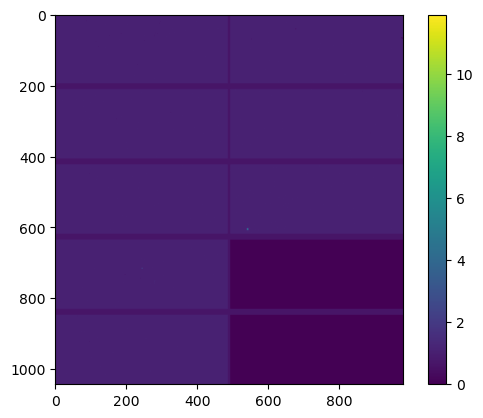

In [4]:
#EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2023_2/beamline/CKe/saxs/'  
EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2023_1/LRichter2/AgBH_cali_13.5kev_openarea/maxs/'
pattern = '*directbeam*'
infiles = glob.glob(os.path.join(EXPR_DIR+'raw/', pattern+'.tiff'))
print(infiles)

data = Data2DScattering()
data.load(infiles[0])
#data.blur(sigma=1)
img = data.data
print('Size = {}'.format(img.shape))

## Plot
%matplotlib inline
plt.figure(1); plt.imshow(np.log(img+3)); plt.colorbar()
beam_center = [np.argmax(np.max(img,0)), np.argmax(np.max(img,1))]
print('Beam center = {}'.format(beam_center))

img[beam_center[1], beam_center[0]] = 0
beam_center = [np.argmax(np.max(img,0)), np.argmax(np.max(img,1))]
print('Beam center = {}'.format(beam_center))

__Calibration: Energy, beam center, SD distance__

1. Specify wavelength 
2. Tweak beam center and SD distance to get the best match for the calibrant


Calibration qlist = [0.1076     0.2152     0.3228     0.4304     0.538      0.6456
 0.7532     0.8608     0.9684     1.076      1.1836     1.2912
 1.3988     1.5064     1.614      2.01123567 2.32237491 3.28433409
 3.85122309 4.02247133 4.64474981 5.06149876 5.19298816]

fit_param = [height, width, prominence]
5 peaks found: [0.0108 0.0647 2.0181 2.3318 3.1138] for fit_prom 0.08891


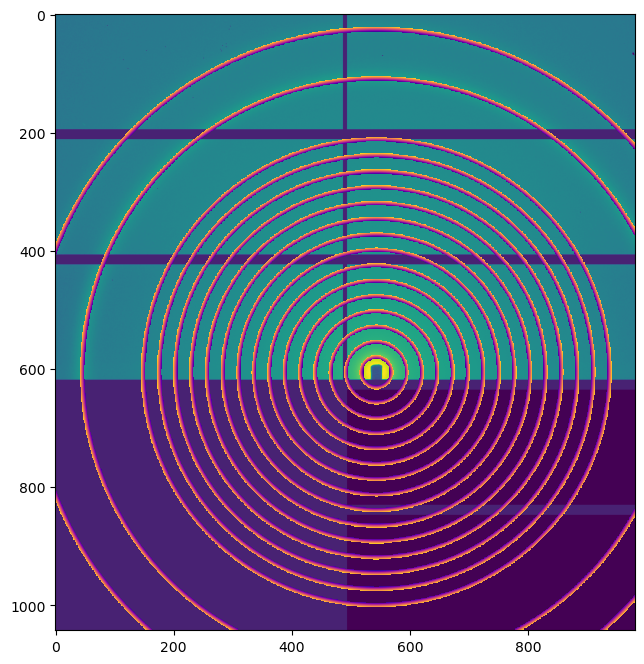

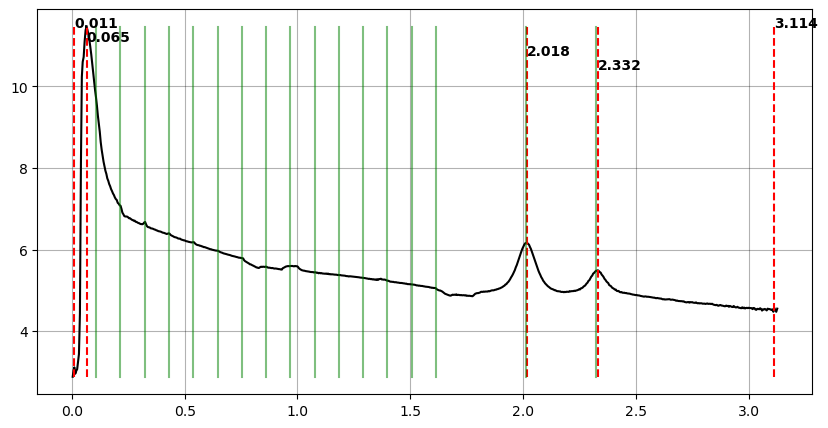

In [5]:
#EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2023_2/beamline/CKe/'
EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2023_1/LRichter2/AgBH_cali_13.5kev_openarea/'
exp = Experiment.experiment('Ag', folder=EXPR_DIR, det='maxs', beamline=None) ##Experiment name: rbitrary or related to the sample name
pattern = '*Ag*1230*'  

exp.defFiles(fn=pattern, verbose=0)     
infiles = exp.dict['rawinfo']['filename']
Nfiles = len(infiles)
    
if 1: #WAXS, MAXS
    #calibration = Calibration(wavelength_A=0.7293) # 17 keV
    calibration = Calibration(wavelength_A=0.9184) #13.5 keV
    calibration.set_image_size(981, height=1043) # Pilatus1M
    calibration.set_pixel_size(pixel_size_um=172.0)
    #calibration.set_beam_position(313.5, 1043-314) #SA, 2023 Apr
    calibration.set_beam_position(543, 606) #LRichter

    #calibration.set_distance(0.259)
    calibration.set_distance(0.2815)
    mask_dir = SciAnalysis_PATH + '/SciAnalysis/XSAnalysis/masks/'
    mask = Mask(mask_dir+'Dectris/Pilatus800k_gaps-mask.png')
    #mask.load(mask_dir+'NSLSII_11BM_CMS/Pilatus800k_CMS_badpixels-mask.png ')

load_args = { 'calibration' : calibration, 
             'mask' : mask,
             }
run_args = { 'verbosity' : 3,
             'AgBH': True, 
             'CeO2': True
           }
process = Protocols.ProcessorXS(load_args=load_args, run_args=run_args)

### Analysis 
protocols = ['circular_average'] 
det = exp.dict['expinfo']['det']
folder = exp.dict['expinfo']['folder']
infile_fullpath = folder+'/'+det+'/raw/'+exp.dict['rawinfo']['filename'][0]+'_'+det+'.tiff'
data = process.load(infile_fullpath, calibration=calibration, mask=mask, run_args=run_args)
line_plot = data.circular_average_q_bin(error=False)


## Plot 2D 
%matplotlib inline
#%matplotlib ipympl

if 1:
    plt.figure(1, figsize=(8,8)); plt.clf()
    plt.imshow(np.log(data.data+3)) #, vmin=2, vmax=9); plt.colorbar() 

    dq = 0.02
    qlist = []
    if 'AgBH' in run_args and run_args['AgBH']:
        q0 = 0.1076
        num_rings = 15
        qlist.extend(q0*np.arange(1,num_rings+1))       
        
    if 'CeO2' in run_args and run_args['CeO2']:
        q0 = (2*np.pi/5.411)*np.sqrt(3)          # A^-1, (111)
        qlist.extend( ( q0/np.sqrt(3) )*np.array((np.sqrt(3), 2, np.sqrt(8),np.sqrt(11),np.sqrt(12),np.sqrt(16),np.sqrt(19),  np.sqrt(20)))  )
    
    qlist.sort();     qlist = np.asarray(qlist)
    print('\nCalibration qlist = {}\n'.format(qlist))    
    
    for q in qlist:
        region = data.calibration.q_map()
        region = np.ma.masked_where(abs(region-q)>dq, region)
        plt.imshow(region, cmap='plasma')

## Plot 1D 
if 1:
    flag_log = 1
    plt.figure(2, figsize=(10,5)); plt.clf()
    q_peaks = Tools.plot_peaks(line_plot, N_peaks_find = 5, fit_param=[0, 1, 0.001], flag_log=flag_log, line_color='k', label_color='r', roundup=3, verbose=1)  #Tools.rand_color(0.5, 0.8)
    
    y_range = [np.min(line_plot.y), np.max(line_plot.y)]
    qlist[qlist > np.max(line_plot.x)] = None
    Tools.label_peaks(qlist, flag_log=flag_log, y_range = y_range, color='g', verbose=0) 
   

__Convert between q and angle__

In [13]:
print('At {} keV'.format(calibration.get_energy()))
print(data.calibration.q_to_angle(1))
print(data.calibration.angle_to_q(20))

At 13.500018665493208 keV
8.38227707099533
2.376009752908029


## 1. Raw data

In [2]:
### Specify directory, detector, and files of interest
if 0: #SAXS
    EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2023_2/beamline/CKe/'
    exp = Experiment.experiment('Ag', folder=EXPR_DIR, det='saxs', beamline='cms') ##Experiment name: rbitrary or related to the sample name
    exp.dict['expinfo']['fn_patterns'] = ['*Ag*1016533*']  

if 0: #WAXS, temperature
    EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2023_1/beamline/ETsai2/' 
    exp = Experiment.experiment('PBG_run1', folder=EXPR_DIR, det='waxs', beamline='cms') ##Experiment name: rbitrary or related to the sample name
    exp.dict['expinfo']['fn_patterns'] = ['*_PBG*run1*x0.0*y0.0*10133*']  #*10133

if 0: #WAXS mapping
    EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2022_3/RHeadrick3/' 
    exp = Experiment.experiment('B6_N3', folder=EXPR_DIR, det='waxs', beamline='cms') ##Experiment name: rbitrary or related to the sample name
    exp.dict['expinfo']['fn_patterns'] = ['*B6_N3_Trans3_map_vac_x*']  

if 1: #MAXS burstmode (series)
    EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2023_1/LRichter2/MM389_KCl/' 
    exp = Experiment.experiment('MM389_KCl', folder=EXPR_DIR, det='maxs', series_measure=True, beamline='None') ##Experiment name: rbitrary or related to the sample name
    exp.dict['expinfo']['fn_patterns'] = ['*MM389*run4*']  
      
    
    
### Load files
try:
    for pattern in exp.dict['expinfo']['fn_patterns']:
        #exp.defFiles_query(fn='PBG', folder=EXPR_DIR, scanid = [900000, 1200000], verbose=1) 
        exp.defFiles(fn=pattern, verbose=1) 
        #exp.defFiles(fn=pattern, scanid = [750000, 900000], verbose=1)  
    
    infiles = exp.dict['rawinfo']['filename']
    Nfiles = len(infiles)
    
except:
    print('\n!!! Databroker not working, loading files directly.')
    #exp.dict['expinfo']['beamline'] = None
    for pattern in exp.dict['expinfo']['fn_patterns']:
        exp.defFiles(fn=pattern, verbose=1)      
    

### Show some info   
exp.show()
exp.showFileInfo(idx=0)


/nsls2/data/cms/legacy/xf11bm/data/2023_1/LRichter2/MM389_KCl/maxs/raw/
Loaded 3600 files.
(defFiles time = 0.1s)

=== Overview of experiment dictionary ===
exp.dict['expinfo']
    keys = ['expname', 'det', 'beamline', 'folder', 'fn_patterns']
    -    key = expname, <class 'str'>, val = MM389_KCl
    -    key = det, <class 'str'>, val = maxs
    -    key = beamline, <class 'NoneType'>, val = None
    -    key = folder, <class 'str'>, val = /nsls2/data/cms/legacy/xf11bm/data/2023_1/LRichter2/MM389_KCl/
    -    key = fn_patterns, <class 'list'>
exp.dict['rawinfo']
    keys = ['filename', 'time', 'clock', 'scan_id', 'uid', 'filenumber', 'series_measure', 'num_frames']
    -    key = filename, <class 'list'>, len(shape) = 3600
    -    key = time, <class 'list'>, val = []
    -    key = clock, <class 'list'>, val = []
    -    key = scan_id, <class 'list'>, len(shape) = 3600
    -    key = uid, <class 'list'>, val = []
    -    key = filenumber, <class 'int'>, val = 3600
    -    key = s

## 2. Metadata

In [8]:
## See metadata for one file
import databroker
cat = databroker.catalog['cms']
h = cat[959455]
h.metadata['start']


Start({'beam_intensity_expected': 20000,
 'beam_size_x_mm': 0.1999979999999999,
 'beam_size_y_mm': 0.049985999999999864,
 'beamline_mode': 'measurement',
 'calibration_energy_keV': 13.5,
 'calibration_wavelength_A': 0.9184,
 'detectors': ['pilatus8002'],
 'experiment_SAF_number': '310313',
 'experiment_alias_directory': '/nsls2/data/cms/legacy/xf11bm/data/2023_1/LRichter2/MM389_KCl',
 'experiment_cycle': '2023_1',
 'experiment_group': 'L. Richter (NIST)',
 'experiment_project': 'In-situ kinetic GIWAXS Studies of Organic '
                       'Electrochemical Transistor Blend Film',
 'experiment_proposal_number': '311034',
 'experiment_type': 'GIWAXS',
 'experiment_user': 'various',
 'exposure_period': 0.1,
 'exposure_time': 0.095,
 'filename': 'MM389_KCl_run4_series_56_5072.5s_RH101.837_x-0.002_th0.140_0.10s_959455.tiff',
 'hints': {'dimensions': [[['time'], 'primary']]},
 'measure_series_num_frames': 3600,
 'measure_type': 'Series_measure',
 'motor_SAXSx': -65.0,
 'motor_SAXSy': -7

In [3]:
### Check metadata at the beamline, identify md of interest, e.g. sample_temperature_D, sample_x
file_idx = 0
scan_id = exp.dict['rawinfo']['scan_id'][file_idx]
exp.showMetadata(scanid=scan_id, md_interest=None)
#exp.showMetadata(scanid=scan_id, md_interest = ['sample_clock', 'sample_temperature_D'])
#exp.showMetadata(scanid=scan_id, md_interest = ['sample_clock', 'sample_x', 'sample_y'])

Databroker catelog currently not working unless at beamline.


()

In [4]:
## Options: (1) load metadata from databroker at beamline. (2) load md from h5. (3) Extract info from filename
md_load_option = 3

## Clear all metadata
exp.dict['metadata'] = {}


## Load metadata
if md_load_option==1: # Load md from databroker, this only works at beamline
    exp.dict['mdata_list'] = ['sample_clock', 'sample_temperature_D'] # Specify metedata to load
    exp.loadMetadata()
    print(exp.dict['metadata'].keys())
    
elif md_load_option==2: # Load md from h5 (previously saved from databroker)
    h5_path = EXPR_DIR+"/data/"
    h5_file = 'B6_N3_metadata.h5'
    exp.dict['metadata'] = h5todict(h5_path+h5_file)


elif md_load_option==3: ## If databroker md is not available nor saved
    infiles = exp.dict['rawinfo']['filename']
    print('Number of files: {}'.format(len(infiles)))

    Ts = []
    sample_x = []
    sample_y = []
    scan_id = []
    frames = []
    for ii, infile in enumerate(infiles):
        temp = infile.split('_')
        if ii==0: print(temp)
        
        #Ts.append(float(infile.split('Linkam')[1].split('C')[0]))
        #sample_x.append(float(temp[-4][1:]))
        #sample_y.append(float(temp[-3][1:]))
        
        Ts.append(float(infile.split('RH')[1].split('_x')[0]))
        #scan_id.append(int(temp[-1]))
        frames.append(int(temp[-1]))

    exp.dict['metadata']['sample_temperature_D'] = Ts
    #exp.dict['metadata']['sample_x'] = np.array(sample_x)
    #exp.dict['metadata']['sample_y'] = np.array(sample_y)
    exp.dict['metadata']['frames'] = frames
    
    print(exp.dict['metadata'].keys())

else:
    print('No metadata loaded to the exp. dictionary!')

Number of files: 3600
['MM389', 'KCl', 'run4', 'series', '57', '5695.1s', 'RH100.764', 'x-0.002', 'th0.140', '0.10s', '959455', '000000']
dict_keys(['sample_temperature_D', 'frames'])


In [15]:
#exp.dict['metadata']['frames']

In [ ]:
### Save metadata (for offline analysis later on)
if 0:
    h5_path = EXPR_DIR+"/data/"
    h5_file = exp.name+'_metadata.h5'
    dicttoh5(exp.dict['metadata'], h5_path+h5_file)
    print(h5_path+h5_file)


## 3. Analysis

We suspect that loading analysis results is slow, faster if processing raw data. However, going through the protocals is also slow; storing it to the exp.dict also takes a bit time.

E.g. 3600 files, 1 protocol, saving to exp.dict: 5min

In [8]:
### Specify beamline config (e.g. beam energy, center, det-sample distance)

if 1: #WAXS, MAXS
    #calibration = Calibration(wavelength_A=0.7293) # 17 keV
    calibration = Calibration(wavelength_A=0.9184) #13.5 keV
    calibration.set_image_size(981, height=1043) # Pilatus1M
    calibration.set_pixel_size(pixel_size_um=172.0)
    calibration.set_beam_position(313.5, 1043-314) #SA, 2023 Apr
    calibration.set_distance(0.259)

    ## LRichter
    calibration.set_beam_position(543, 606) #LRichter
    calibration.set_distance(0.2815)
    
    mask_dir = SciAnalysis_PATH + '/SciAnalysis/XSAnalysis/masks/'
    mask = Mask(mask_dir+'Dectris/Pilatus800k_gaps-mask.png')
    #mask.load(mask_dir+'NSLSII_11BM_CMS/Pilatus800k_CMS_badpixels-mask.png ')

if 0: #SAXS   
    calibration = Calibration(wavelength_A=0.9184) # 13.5 keV
    calibration.set_image_size(1475, height=1679) # Pilatus2M
    calibration.set_pixel_size(pixel_size_um=172.0)

    calibration.set_beam_position(757, 1679-600) # SAXSx -65, SAXSy -73    
    calibration.set_distance(5.02)    

    mask_dir = SciAnalysis_PATH + '/SciAnalysis/XSAnalysis/masks/'
    if 1: #flag_stitch
        mask = Mask(mask_dir+'Dectris/Pilatus2M_vertical_gaps-mask.png')
    else:
        mask = Mask(mask_dir+'Dectris/Pilatus2M_gaps-mask.png')
    mask.load(EXPR_DIR+'saxs/analysis/mask_saxs.png')    
    
    
load_args = { 'calibration' : calibration, 
             'mask' : mask,
             #'rot180' : False,
             #'flip' : True, # PSCCD
             }
run_args = { 'verbosity' : 3,
            #'save_results' : ['xml', 'plots', 'txt', 'hdf5'],
            }
process = Protocols.ProcessorXS(load_args=load_args, run_args=run_args)
#infiles = exp.dict['expinfo']['filename']


### Run analysis 
protocols = ['circular_average'] #['linecut_angle'] #['circular_average'] #, 'sector_average', 'linecut_qz']

exp.dict['analysis']['cali'] = [calibration.wavelength_A, calibration.x0, calibration.y0, calibration.distance_m]
#exp.dict['analysis'] = {} 
#for protocol in protocols:
#    exp.dict['analysis'][protocol] = {}

t0 = time.time()  
    
line_y_stack = []
for protocol in protocols:
    if 'circular_average' in protocol:
        for ii, infile in enumerate(infiles):
            if np.mod(ii+1, 100)==0: print('[{:.0f}%]'.format(ii/Nfiles*100))

            det = exp.dict['expinfo']['det']
            folder = exp.dict['expinfo']['folder']

            infile_fullpath = folder+'/'+det+'/raw/'+exp.dict['rawinfo']['filename'][ii]+'_'+det+'.tiff'
            data = process.load(infile_fullpath, calibration=calibration, mask=mask, run_args=run_args)

            ### Run the protocol
            line_output = data.circular_average_q_bin(error=False)
            line_y_stack.append(line_output.y)

            if 0:
                exp.dict['analysis'][protocol][str(ii)] = {}
                exp.dict['analysis'][protocol][str(ii)]['q'] = line_output.x
                exp.dict['analysis'][protocol][str(ii)]['I(q)'] = line_output.y
        
        ### Save analysis to exp.dict
        if 1:
            exp.dict['analysis'][protocol] = {}
            exp.dict['analysis'][protocol]['q'] = line_output.x
            exp.dict['analysis'][protocol]['I_stack'] = line_y_stack   


            #x = Protocols.thumbnails(name=None) 
            #x.run(data, output_dir)
            
    #elif 'sector_average' in protocol: 
    #    line_output = data.sector_average_q_bin(angle=60, dangle=5)

    #elif 'linecut_qz' in protocol:
    #    line_output = data.linecut_qz(qr=0, dq=0.05)

    #elif 'linecut_angle' in protocol:
    #line_output = data.linecut_angle(q0=2.24, dq=0.01)
            
        
print('Done! (Analysis took {:.0f}s)\n'.format(time.time()-t0))

now = datetime.datetime.now()
dt_string = now.strftime("%Y/%m/%d %H:%M:%S")
print("{}\n".format(dt_string))

print(exp.dict['analysis'].keys())

[3%]
[6%]
[8%]
[11%]
[14%]
[17%]
[19%]
[22%]
[25%]
[28%]
[31%]
[33%]
[36%]
[39%]
[42%]
[44%]
[47%]
[50%]
[53%]
[56%]
[58%]
[61%]
[64%]
[67%]
[69%]
[72%]
[75%]
[78%]
[81%]
[83%]
[86%]
[89%]
[92%]
[94%]
[97%]
[100%]
Done! (Analysis took 303s)

2023/05/11 14:33:34

dict_keys(['cali', 'circular_average'])


In [9]:
exp.show()


=== Overview of experiment dictionary ===
exp.dict['expinfo']
    keys = ['expname', 'det', 'beamline', 'folder', 'fn_patterns']
    -    key = expname, <class 'str'>, val = MM389_KCl
    -    key = det, <class 'str'>, val = maxs
    -    key = beamline, <class 'NoneType'>, val = None
    -    key = folder, <class 'str'>, val = /nsls2/data/cms/legacy/xf11bm/data/2023_1/LRichter2/MM389_KCl/
    -    key = fn_patterns, <class 'list'>
exp.dict['rawinfo']
    keys = ['filename', 'time', 'clock', 'scan_id', 'uid', 'filenumber', 'series_measure', 'num_frames']
    -    key = filename, <class 'list'>, len(shape) = 3600
    -    key = time, <class 'list'>, val = []
    -    key = clock, <class 'list'>, val = []
    -    key = scan_id, <class 'list'>, len(shape) = 3600
    -    key = uid, <class 'list'>, val = []
    -    key = filenumber, <class 'int'>, val = 3600
    -    key = series_measure, <class 'bool'>, val = True
    -    key = num_frames, <class 'int'>, val = 3600
exp.dict['analysis'

__Instead of doing analysis, can load previously analyzed data__

In [468]:
if 0:
    exp.loadSciAnalysisData(keys=['circular_average'], analysis_folder=str(exp.dict['folder'])+'waxs/analysis/PBG_run1/', verbose=1)
    exp.dict['analysis'].keys()

analysis_folder = /nsls2/data/cms/legacy/xf11bm/data/2023_1/beamline/ETsai2/waxs/analysis/PBG_run1/
[0%] 
[43%] 
[85%] 
loadSciAnalysisData time = 16.5s


dict_keys(['circular_average'])

## 4. Save 

Save experiment dictionary (exp.dict) to h5.

In [21]:
h5_path = EXPR_DIR+"/data/"
h5_file = str(exp.dict['expinfo']['expname']) + '_cms_exp.h5'
output_file = h5_path+h5_file


## Check if file exist, will not overwrite
if False:
    file_exist = os.path.isfile(output_file)
    count = 1
    while file_exist:
        print('{} exists, using a new filename'.format(output_file))
        h5_file = str(exp.dict['expname']) + '_exp_' + str(count) + '.h5'
        output_file = h5_path+h5_file
        file_exist = os.path.isfile(output_file)
        count = count + 1

        
## Save
dicttoh5(exp.dict, output_file)
print('Experiment saved as {}'.format(output_file))



Experiment saved as /nsls2/data/cms/legacy/xf11bm/data/2023_1/LRichter2/MM389_KCl//data/MM389_KCl_cms_exp.h5


In [22]:
exp_dict_load['expinfo']

{'det': array('maxs', dtype='<U4'),
 'expname': array('MM389_KCl', dtype='<U9'),
 'fn_patterns': array(['*MM389*run4*'], dtype=object),
 'folder': array('/nsls2/data/cms/legacy/xf11bm/data/2023_1/LRichter2/MM389_KCl/',
       dtype='<U62'),
 'beamline': 'None'}

### __Load H5__

Load experiment dictionary and recover the object 'exp', allowing for subsequent data visualization/analysis.

In [2]:
#%matplotlib nbagg
# Imports
########################################
import sys, os, time, glob, imageio, datetime, pprint
import sqlite3
import pandas as pd
from silx.io.dictdump import dicttoh5, h5todict
SciAnalysis_PATH='/nsls2/data/cms/legacy/xf11bm/software/SciAnalysis/' ### Specify this
SciAnalysis_PATH in sys.path or sys.path.append(SciAnalysis_PATH)
from SciAnalysis import tools
from SciAnalysis.XSAnalysis.Data import *
from SciAnalysis.XSAnalysis import Protocols
from SciAnalysis.ExpAnalysis import Experiment
from SciAnalysis.ExpAnalysis import Tools


### Load experiment dict (previuosly analyzed data)
if True:
    
    #exp_dict_h5 = '/nsls2/data/cms/legacy/xf11bm/data/2022_3/RHeadrick3//data/B6_N3_cms_exp.h5'
    #exp_dict_h5 = '/nsls2/data/cms/legacy/xf11bm/data/2023_1/beamline/ETsai2//data/PBG_run1_cms_exp.h5'
    exp_dict_h5 = '/nsls2/data/cms/legacy/xf11bm/data/2023_1/LRichter2/MM389_KCl//data/MM389_KCl_cms_exp.h5'
    exp_dict_load = h5todict(exp_dict_h5)
    #print(exp_dict_load.keys())
    
    exp = Experiment.experiment(exp_dict_load['expinfo']['expname'], folder=exp_dict_load['expinfo']['folder'], det=exp_dict_load['expinfo']['det'], beamline=exp_dict_load['expinfo']['beamline']) 
    exp.dict = exp_dict_load
    
    print(exp.dict.keys())
    print('\nExperiment loaded!')

dict_keys(['advanced', 'analysis', 'expinfo', 'metadata', 'rawinfo'])

Experiment loaded!


### __Overview of exp__

In [3]:
exp.show(verbose=1)


=== Overview of experiment dictionary ===
exp.dict['advanced']
  -  keys = []
exp.dict['analysis']
  -  keys = ['cali', 'circular_average']
  -  key = cali, <class 'numpy.ndarray'>, val = [9.184e-01 5.430e+02 6.060e+02 2.815e-01]
  -  key = circular_average
  -  -  keys = ['I_stack', 'q']
  -  -  key = I_stack, <class 'numpy.ndarray'>, val.shape = (3600, 748)
  -  -  key = q, <class 'numpy.ndarray'>, val.shape = (748,)
exp.dict['expinfo']
  -  keys = ['beamline', 'det', 'expname', 'fn_patterns', 'folder']
  -  key = beamline, <class 'numpy.ndarray'>, val = None
  -  key = det, <class 'numpy.ndarray'>, val = maxs
  -  key = expname, <class 'numpy.ndarray'>, val = MM389_KCl
  -  key = fn_patterns, <class 'numpy.ndarray'>, val = ['*MM389*run4*']
  -  key = folder, <class 'numpy.ndarray'>, val = /nsls2/data/cms/legacy/xf11bm/data/2023_1/LRichter2/MM389_KCl/
exp.dict['metadata']
  -  keys = ['frames', 'sample_temperature_D']
  -  key = frames, <class 'numpy.ndarray'>, val.shape = (3600,)
 

In [30]:
type(exp.dict['analysis']['circular_average'])

dict

## 5. Plot

### Option 1. 

#### &#9642; __Plot curves__

##### - __Load one curve & find peaks__

circular_average
AgBH_cali_5m_13.5kev_x0.700_th0.000_10.00s_1016533
fit_param = [height, width, prominence]
18 peaks found: [0.0438 0.0447 0.0456 0.0466 0.1069 0.1475 0.1592 0.1627 0.1669 0.1686
 0.1705 0.1726 0.1745 0.1749 0.1756 0.1766 0.1789 0.181 ] for fit_prom 0.00100


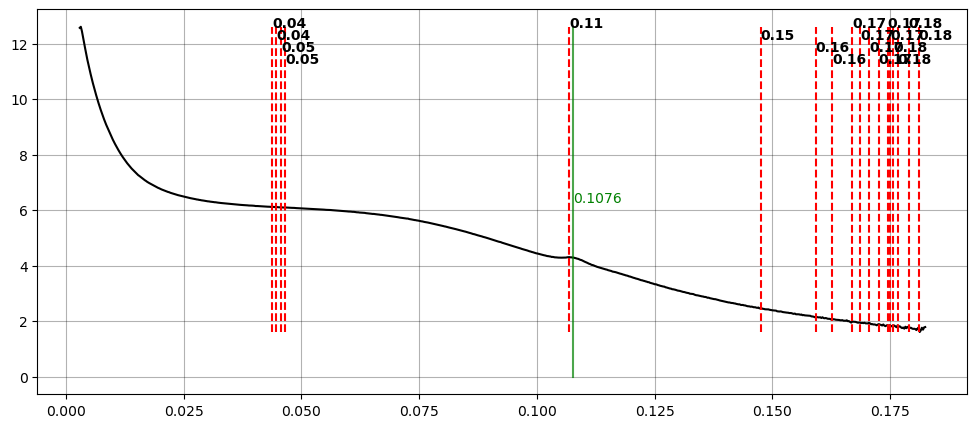

In [31]:
### Show one curve and find peaks

#protocol = 'circular_average'
protocol = list(exp.dict['analysis'].keys())[-1]
print(protocol)
print(exp.dict['rawinfo']['filename'][-1])

## Pick a curve
file_idx = 0
line_plot = DataLine(x = exp.dict['analysis'][protocol]['q'], y = exp.dict['analysis'][protocol]['I_stack'][file_idx])  
flag_log = 1

%matplotlib inline
#%matplotlib ipympl
plt.figure(1, figsize=(12,5)); plt.clf()
q_peaks = Tools.plot_peaks(line_plot, N_peaks_find = 25, fit_param=[0, 1, 0.001], flag_log=flag_log, line_color='k', label_color='r', verbose=1)  #Tools.rand_color(0.5, 0.8)


q_label = [0.1076]
for q in q_label:
    if flag_log:
        y_range = [0, max(np.log(line_plot.y))]
    else:
        y_range = [min(line_plot.y), max(np.log(line_plot.y))]
    plt.plot([q, q], y_range, 'g',  alpha=0.7)
    plt.text(q, y_range[1]/2, str(q), color='g')


##### - __Plot curves for experiment__

In [14]:
%matplotlib inline
plt.figure(1, figsize=(12,10)); plt.clf()
Nfiles = len(exp.dict['rawinfo']['filename'])
infile = exp.dict['rawinfo']['filename'][0]

qrange_plot = [0.5, 3.9] ###
q_label = q_peaks #[1.278, 1.88, 2.219, 2.564, 2.905]; # Label the lines

cmap = mpl.colormaps['jet'] #viridis, jet, hsv, brg
colors = cmap(np.linspace(0.0, 1.0, Nfiles))
flag_log = 1

sample_temperature_D = exp.dict['metadata']['sample_temperature_D']
#sample_x = exp.dict['metadata']['sample_x']



### Plot
x_axis = exp.dict['analysis'][protocol]['q'] 
idx_min = int(np.argmin(np.abs(x_axis-qrange_plot[0])))
idx_max = int(np.argmin(np.abs(x_axis-qrange_plot[1])))

I_stack = exp.dict['analysis'][protocol]['I_stack']
spacing_plot = 0.7 #arbitrary

if flag_log:
    I_stack = np.log(I_stack)
    
    
for ii in np.arange(Nfiles):
    if sample_temperature_D[ii]>349.8:
        color = 'r'
        linestyle = None #'dashed' #dotted, dashed
    else:
        color = colors[ii]*0.8
        linestyle = None
        
    plt.plot(x_axis[idx_min:idx_max],I_stack[ii][idx_min:idx_max]+ii*spacing_plot, linestyle=linestyle, color=color, label=sample_temperature_D[ii])
    #plt.grid('minor')

for q in q_label:
    plt.plot([q, q], [min(I_stack[0])*0.8, max(I_stack[0])*1.2+Nfiles*spacing_plot], 'k',  alpha=0.2)

    
plt.legend(fontsize=7, ncols=7, bbox_to_anchor=(1.01, 1.01)) 
plt.title('{}, N={}'.format(infile.split('raw')[-1], Nfiles))



KeyError: 'sample_temperature_D'

<Figure size 1200x1000 with 0 Axes>

##### - __Plot all curves as 2D image__

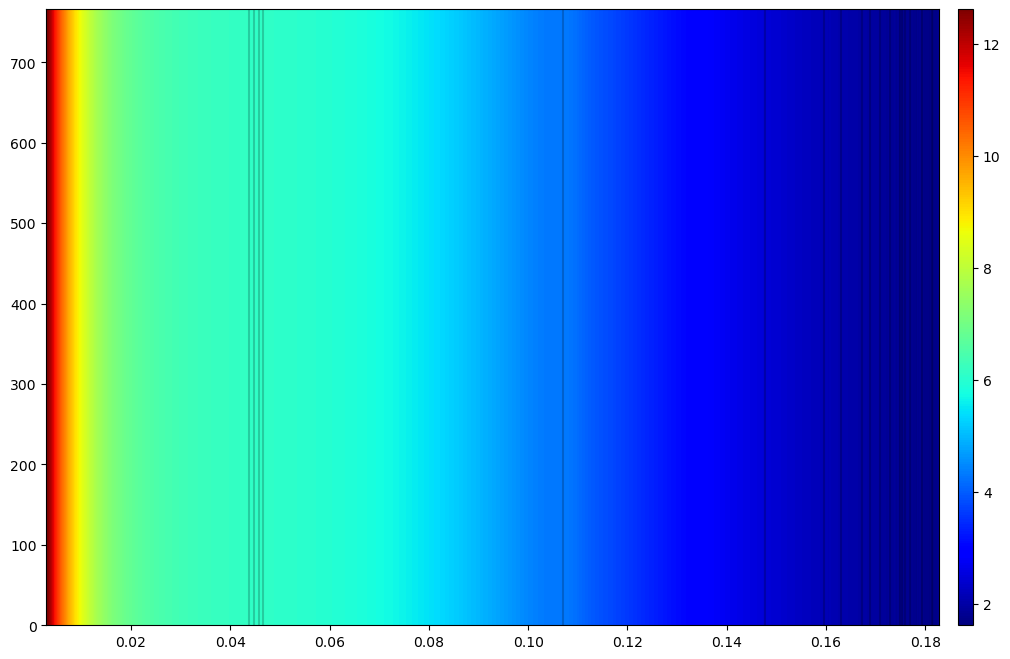

In [18]:
q_label = q_peaks #[1.278, 1.88, 2.219, 2.564, 2.905]; # Label the lines
flag_log = True

protocol = 'circular_average'
#protocol = list(exp.dict['analysis'].keys())[-1]



x_axis = exp.dict['analysis'][protocol]['q'] 
I_stack = exp.dict['analysis'][protocol]['I_stack']
if flag_log:
    I_stack = np.log(I_stack)
    
%matplotlib inline
plt.figure(2, figsize=(12,8)); plt.clf()
plt.imshow(I_stack, origin='lower', cmap='jet', extent = [np.min(x_axis), np.max(x_axis), 0, I_stack.shape[1]],  aspect='auto') #aspect='auto' 0.005
cbar = plt.colorbar(fraction=0.02, pad=0.02, aspect=40) 
     
for q in q_label:
    plt.plot([q, q], [0, I_stack.shape[1]], 'k',  alpha=0.2)
    

#### &#9642; __Extract 0D feature & Plot 1D__

##### - __Load one curve for peak fitting__

{'fit_peaks_b': {'error': None, 'value': 1.9260901959810135},
 'fit_peaks_chi_squared': 0.020714021277798186,
 'fit_peaks_d0': {'error': 0.0, 'value': 0.3449356099389584},
 'fit_peaks_d01': {'error': 0.0, 'value': 0.3449356099389584},
 'fit_peaks_d02': {'error': 0.0, 'value': 0.3378056616763218},
 'fit_peaks_grain_size': {'error': 0.0, 'value': 10.15423389568423},
 'fit_peaks_grain_size1': {'error': 0.0, 'value': 10.15423389568423},
 'fit_peaks_grain_size2': {'error': 0.0, 'value': 10.15423389568423},
 'fit_peaks_m': {'error': None, 'value': 1.741598649990845},
 'fit_peaks_prefactor1': {'error': None, 'value': 0.0},
 'fit_peaks_prefactor2': {'error': None, 'value': 0.0},
 'fit_peaks_prefactor_total': 0.0,
 'fit_peaks_qalpha': {'error': None, 'value': 1.0},
 'fit_peaks_qp': {'error': None, 'value': 0},
 'fit_peaks_sigma1': {'error': None, 'value': 0.024685547923968664},
 'fit_peaks_sigma2': {'error': None, 'value': 0.024685547923968664},
 'fit_peaks_x_center1': {'error': None, 'value': 

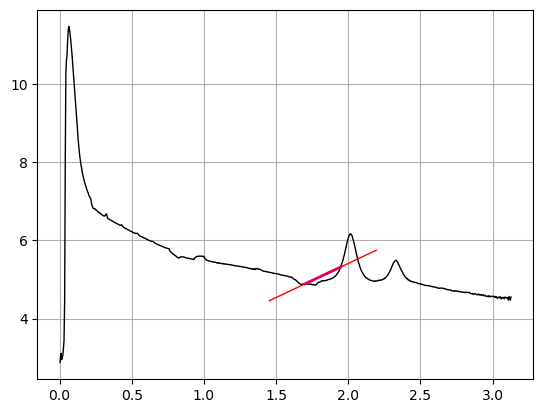

In [15]:
### Show one curve & do fitting
protocol = 'circular_average'

file_idx = 0
line_plot = DataLine(x = exp.dict['analysis'][protocol]['q'], y = exp.dict['analysis'][protocol]['I_stack'][file_idx])  

q0 = [1.82, 1.86]
fit_range = [1.7, 1.95]
flag_log = True

if flag_log == 1:
    line_plot.y = np.log(line_plot.y)

## Fitting
run_args = { 'verbosity' : 3,
             #'fittype': 'voigt',
            }
results = {}
protocol = Protocols.fit_peaks()
lines = protocol._fit(line_plot, results, **run_args, q0=q0, num_curves=len(q0), fit_range=fit_range)



pprint.pprint(lines.results)
for nn, line in enumerate(lines.lines):
        
    if nn==0: 
        plt.plot(line.x, line.y, 'k', linewidth=1, label=line.name)
        plt.title(line.name)
    elif nn==1:
        plt.plot(line.x, line.y, 'm', linewidth=2, label=line.name)
    else:
        plt.plot(line.x, line.y, 'r', linewidth=1, label=line.name)
        
    plt.grid()

__Apply fitting for the experiment__

In [18]:
protocol = 'circular_average'
q0 = [1.82, 1.86]
fit_range = [1.7, 1.95]


## Fitting
run_args = { 'verbosity' : 3,
             #'fittype': 'voigt',
            }
p = Protocols.fit_peaks()
    

## Fitting all curves
peak_x1 = []
peak_x2 = []
peak_pre1 = []
t0 = time.time()
for ii in np.arange(Nfiles):
    line_plot = DataLine(x = exp.dict['analysis'][protocol]['q'], y = exp.dict['analysis'][protocol]['I_stack'][ii])  
    
    lines = p._fit(line_plot, results={}, **run_args, q0=q0, num_curves=2, fit_range=fit_range)

    peak_x1.append(lines.results['fit_peaks_x_center1']['value'])
    peak_x2.append(lines.results['fit_peaks_x_center2']['value'])
    peak_pre1.append(lines.results['fit_peaks_prefactor1']['value'])

print('Fitting took {:.0f}s\n'.format(time.time()-t0))

#Ts = exp.dict['metadata']['sample_temperature_D']
#scan_ids = exp.dict['rawinfo']['scan_id']


Fitting took 0s



In [19]:
exp.dict['analysis']['circular_average']['fit_peaks_x_center1'] = peak_x1
exp.dict['analysis']['circular_average']['fit_peaks_x_center2'] = peak_x2
exp.show()


=== Overview of experiment dictionary ===
exp.dict['analysis']
    keys = ['cali', 'circular_average']
    -    key = cali, val = [9.184e-01 3.135e+02 7.290e+02 2.590e-01]
    -    keys = ['I_stack', 'q', 'fit_peaks_x_center1', 'fit_peaks_x_center2']
    -    -    key = I_stack, val.shape = (29, 751)
    -    -    key = q, val.shape = (751,)
    -    -    key = fit_peaks_x_center1, len(shape) = 29
    -    -    key = fit_peaks_x_center2, len(shape) = 29
exp.dict['corr']
    key = corr, val = []
exp.dict['corrdata']
exp.dict['exp_protocol']
    key = exp_protocol, val = []
exp.dict['expinfo']
    keys = ['beamline', 'det', 'expname', 'fn_patterns', 'folder']
    -    key = beamline, val = cms
    -    key = det, val = waxs
    -    key = expname, val = PBG_run1
    -    key = fn_patterns, val = ['*_PBG*run1*x0.0*y0.0*10133*']
    -    key = folder, val = /nsls2/data/cms/legacy/xf11bm/data/2023_1/beamline/ETsai2/
exp.dict['mdata_list']
    key = mdata_list, val = ['sample_clock' 'sample

In [30]:
#Convert list or dict to dataframe:
df_list = pd.DataFrame(peak_x1, columns=['peak_x1'])


__Alternatively, other feature extration (e.g. q with max intensity)__

In [ ]:
### Get the q with max intensity within this range

protocol = 'circular_average'
y = []
for ii in np.arange(Nfiles):
    line_plot = DataLine(x = exp.dict['data'][protocol][str(ii)]['q'], y = exp.dict['data'][protocol][str(ii)]['I(q)'])  
    line_x = line_plot.x
    line_y = line_plot.y
    y.append(line_y[idx_min:idx_max])
    
qrange_plot = [1, 1.5] 


Ts = exp.dict['metadata']['sample_temperature_D']
scan_ids = exp.dict['expinfo']['scan_id']

idx_min = int(np.argmin(np.abs(x_axis-qrange_plot[0])))
idx_max = int(np.argmin(np.abs(x_axis-qrange_plot[1])))

x_axis = line_x
q_peakmax_list = []
data_show = []
for ii in np.arange(len(y)):
    line_y = y[ii]
    line_y_crop = line_y[idx_min:idx_max]
    line_x_crop = x_axis[idx_min:idx_max]
    q_peakmax = line_x_crop[np.argmax(line_y_crop)]
    q_peakmax_list.append(q_peakmax)
    data_show.append([Ts[ii], scan_ids[ii], q_peakmax])

df_line_s = pd.DataFrame(q_peakmax_list, columns=['I'])
df_show = pd.DataFrame(data_show, columns = ['RH', 'scan_id', 'q_peakmax'])

print(q_peakmax_list[0:5])

##### - __Compare three 1D curves__

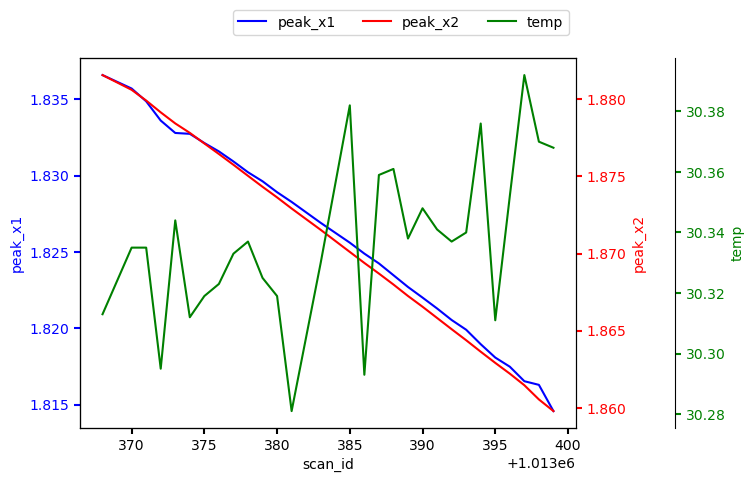

In [22]:
Ts = exp.dict['metadata']['sample_temperature_D']
scan_ids = exp.dict['rawinfo']['scan_id']


fig, ax = plt.subplots()
#fig.subplots_adjust(right=0.75)

twin1 = ax.twinx()
twin2 = ax.twinx()
twin2.spines.right.set_position(("axes", 1.2))


if 1:
    labels = ["peak_x1", "peak_x2", "temp"]
    p1, = ax.plot(scan_ids, peak_x1, "b-", label=labels[0])
    p2, = twin1.plot(scan_ids, peak_x2, "r-", label=labels[1])
    p3, = twin2.plot(scan_ids, Ts, "g-", label=labels[2])
else:
    p1, = ax.plot(scan_ids, q_peakmax_list, "b-", label="q")
    p2, = twin1.plot(scan_ids, np.array(Ts), "r-", label="Temperature")
    #p3, = twin2.plot([0, 1, 2], [50, 30, 15], "g-", label="Humidity")
    

#ax.set_xlim(0, 2)
#ax.set_ylim(0, 2)
#twin1.set_ylim(0, 4)
#twin2.set_ylim(1, 65)

ax.set_xlabel("scan_id")
ax.set_ylabel(labels[0])
twin1.set_ylabel(labels[1])
twin2.set_ylabel(labels[2])

ax.yaxis.label.set_color(p1.get_color())
twin1.yaxis.label.set_color(p2.get_color())
twin2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
twin1.tick_params(axis='y', colors=p2.get_color(), **tkw)
twin2.tick_params(axis='y', colors=p3.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax.legend(handles=[p1, p2, p3], ncols=3, bbox_to_anchor=(1, 1.15))
plt.show()

#### &#9642; __Extract 0d feature & Plot 2D map__

In [ ]:
### ROI
if 0:
    reduced_data = exp.dict['data']['roi']
    print('Len(reduced_data) = {}'.format(len(reduced_data)))
    print(reduced_data.keys())

    feature_list = []
    for ii in np.arange(0,len(reduced_data)):
        feature_list.append(reduced_data['stats_average'][ii])

In [481]:
### Angle

reduced_data = exp.dict['data']['linecut_angle']
print('Len(reduced_data) = {}'.format(len(reduced_data)))

x_pos = exp.dict['metadata']['sample_x']
y_pos = exp.dict['metadata']['sample_y']


feature_list = []
for ii in np.arange(0,len(reduced_data)):
    angle = reduced_data[str(ii)]['q']
    I = reduced_data[str(ii)]['I(q)']
    chi = angle[np.argmax(I)]
    feature_list.append(chi)


Len(reduced_data) = 3450


##### - __Plot scalar 2D mage__

(-2.5, 2.4000500000000002, -1.8000500000000001, 1.6000500000000002)

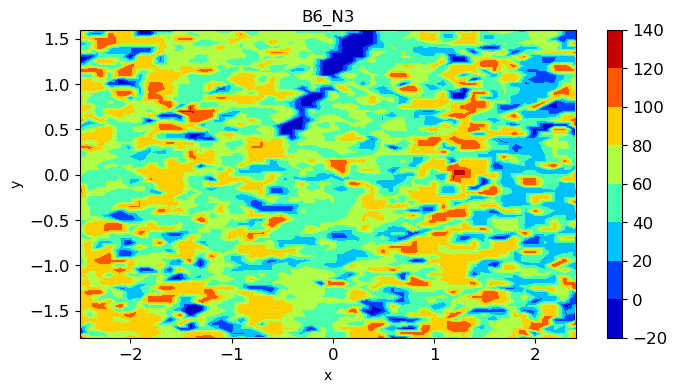

In [482]:
plt.figure(); plt.clf()

#plt.tripcolor(x_pos, y_pos, feature_list)  
plt.tricontourf(x_pos, y_pos, feature_list, cmap = 'jet') 

plt.colorbar()
plt.xlabel('x'); plt.ylabel('y')
plt.title(exp.dict['expname'])
plt.axis('equal')
plt.axis('tight')

#plt.plot(x_pos, y_pos, 'k.')

__Plot scalar image with interpolation__

(-2.5, 2.3999999999998956, -1.8000500000000001, 1.5999499999999274)

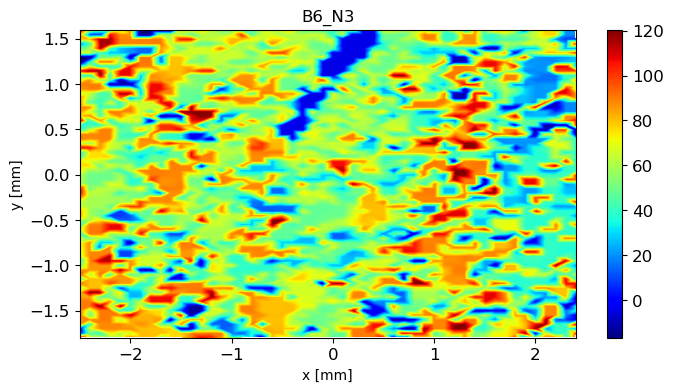

In [437]:
plot_interp = ['linear', 0.005] 
x_pos_fine, y_pos_fine, feature = Tools.interp_map(x_pos, y_pos, feature_list, plot_interp) 

plt.figure(); 
extent = (np.nanmin(x_pos_fine), np.nanmax(x_pos_fine), np.nanmin(y_pos_fine), np.nanmax(y_pos_fine))

plt.imshow(feature, extent=extent, origin='lower', cmap='jet') #, clim=[-180, 180])  
plt.colorbar()
plt.xlabel('x [mm]'); plt.ylabel('y [mm]')
plt.title(exp.dict['expname'])
plt.axis('equal')
plt.axis('tight')

##### - __Plot quiver__

In [438]:
u_list = []
v_list = []
chi_list = []
for chi in feature_list:
    u = np.cos(np.deg2rad(chi)) 
    v = np.sin(np.deg2rad(chi)) 
    u_list.append(u)
    v_list.append(v)
    chi_list.append(chi)

Text(0.5, 1.0, 'PBG_run1')

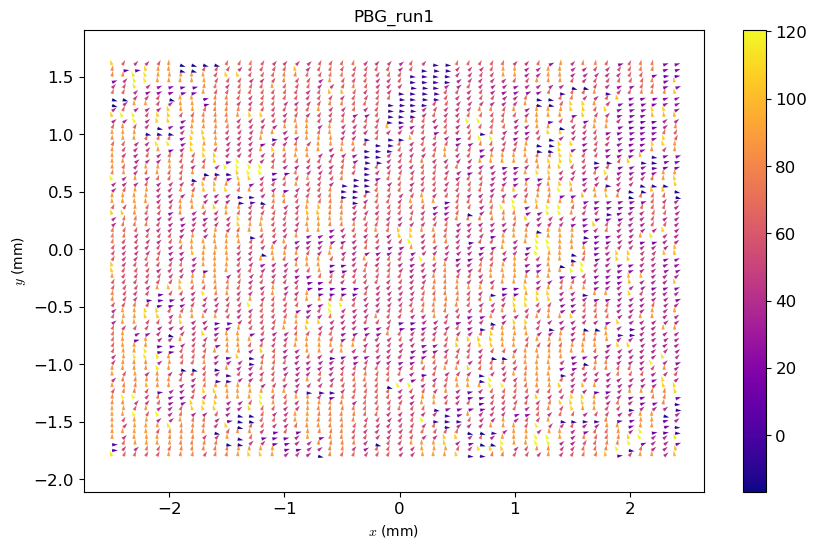

In [459]:
fig, ax = plt.subplots(figsize=[10, 6])

q = ax.quiver(x_pos, y_pos, u_list, v_list, chi_list, cmap = 'plasma') #,clim=[0,0.3])

#ax.set_xlim([-0.2,5])
#ax.set_ylim([-0.2,5])
ax.axis('equal')
ax.set_xlabel('$x$ (mm)'); ax.set_ylabel('$y$ (mm)')

cb = plt.colorbar(q)
plt.title(exp.dict['expname'])
# plt.savefig('SAXS mapping_quiver polt_colorbar.png', dpi = 600)


### Option 2. 

#### &#9642; Perform correlation 

In [461]:
print('Analysis data: {}\n'.format(exp.dict['data'].keys()))
exp.doCorr(corrs = [['2Darray']])

print(exp.dict['corrdata']['2Darray']['circular_average'].keys())
print(exp.dict['data']['circular_average'][str(0)].keys())

Analysis data: dict_keys(['circular_average'])

doCorr circular_average
dict_keys(['I(q)', 'I_array', 'file_index', 'scan_id', 'time', 'sample_clock', 'sample_temperature_D'])
dict_keys(['I(q)', 'q'])


#### &#9642; Plot data

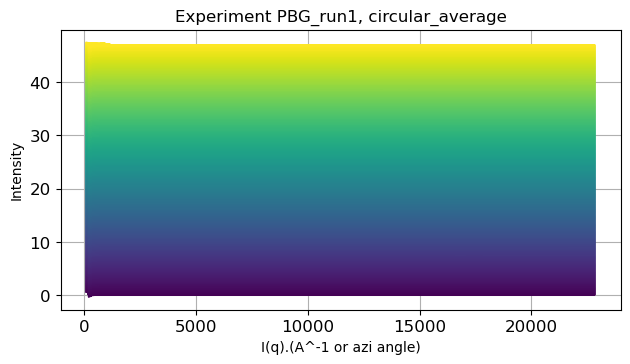

In [462]:
%matplotlib inline

exp.plotWaterfall(key = 'circular_average', y_spacing=0.1, flag_log=[0, 1])
#exp.plotWaterfall(key = 'sector_average', y_spacing=1)
#exp.plotWaterfall(key = 'linecut_qz', y_spacing=100)

/nsls2/data/cms/legacy/xf11bm/software/SciAnalysis/SciAnalysis/ExpAnalysis/Experiment.py:518: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(x_axis[plot_xrange], y_idx, I_array[:,plot_xrange])


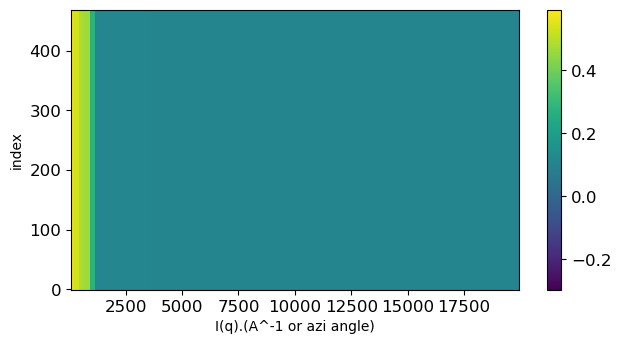

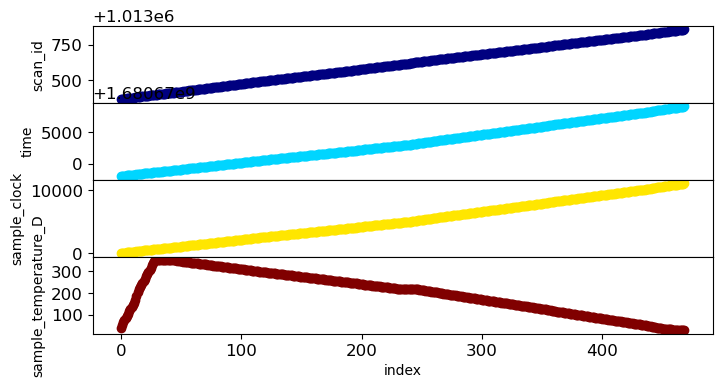

In [463]:
exp.plotHeatmap(key = protocol)

## 6. Batch Processing (usually done in background)

In [ ]:
load_args = { 'calibration' : calibration, 
             'mask' : mask,
             #'rot180' : False,
             #'flip' : True, # PSCCD
             }
run_args = { 'verbosity' : 3,
            'rcParams': {'axes.labelsize': 25,
                            'xtick.labelsize': 18,
                            'ytick.labelsize': 18,
                            'xtick.major.pad': 5,
                            'ytick.major.pad': 5,
                            },
            }

process = Protocols.ProcessorXS(load_args=load_args, run_args=run_args)

# Examples:
#protocols = [ Protocols.circular_average_q2I(plot_range=[0, 0.2, 0, None]) ]
#protocols = [ Protocols.linecut_angle(q0=0.01687, dq=0.00455*1.5, show_region=False) ]
#protocols = [ Protocols.q_image(blur=1.0, bins_relative=0.5, plot_range=[-0.1, 3.0, 0, 3.0], _xticks=[0, 1.0, 2.0, 3.0], ztrim=[0.2, 0.01]) ]
#protocols = [ Protocols.qr_image(blur=1.0, bins_relative=0.5, plot_range=[-0.1, 3.0, 0, 3.0], _xticks=[0, 1.0, 2.0, 3.0], zmin=1010., ztrim=[None, 0.01]) ]
#protocols = [ Protocols.qr_image(blur=None, bins_relative=0.8, plot_range=[-0.1, 3.0, 0, 3.0], _xticks=[0, 1.0, 2.0, 3.0], ztrim=[0.38, 0.002], dezing_fill=True) ]
#protocols = [ Protocols.q_phi_image(bins_relative=0.25, plot_range=[0, 3.0, 0, +90]) ]
# Protocols.sector_average(angle=-70, dangle=25, show_region=False) 
# Protocols.qr_image(blur=None, colorbar=True, save_data=False, transparent=False, label_filename=True) 
# Protocols.linecut_q(chi0= 90+70, dq= .5, gridlines=True, label_filename=True, save_results = [ 'hdf5' ] )
# Protocols.HDF5(  save_results = [ 'hdf5' ] )
# Protocols.metadata_extract()

protocols = [
    #Protocols.HDF5(save_results=['hdf5'])
    #Protocols.calibration_check(show=False, AgBH=True, q0=1.076, dq=0.005, num_rings=10, ztrim=[0.2, 0.01], dpi=300) ,
    
    Protocols.circular_average(ylog=True, plot_range=[0, 0.18, None, None], dezing=True, gridlines=True, transparent=False, label_filename=True) ,
    #Protocols.thumbnails(crop=None, resize=0.5, cmap=cmap_vge, ztrim=[0.06, 0.001], zmin=1000.0) , # PSCCD
    
    #Protocols.thumbnails(crop=None, resize=0.5, cmap=cmap_vge, ztrim=[0.02, 0.001]) , # Pilatus800k
    #Protocols.thumbnails(name='thumbnails_jet', crop=None, ztrim=[0.06, 0.001]) , # Pilatus800k

    Protocols.qr_image(blur=None, colorbar=True, save_data=False, transparent=False, label_filename=True, plot_buffers = [0.1, 0.1, 0.1, 0.1]),    
    #Protocols.q_image(blur=None, colorbar=True, save_data=False, transparent=False, label_filename=True, plot_buffers = [0.1, 0.1, 0.1, 0.1], dpi=200) 

    ]
    
# To stitch files: 
# 1) run stitch.py to stitch into .TIFF 
# 2) run runStitched.py to generate thumbnails etc

# Run
########################################
print('Processing {} infiles...'.format(len(infiles)))
process.run(infiles, protocols, output_dir=output_dir, force= 1)


# &#9635; Supplementary

 ## S1. Background subtraction 
 
 Same as Sections 0 and 3, except we specify background in __load_args__:
 
 - 'background' can be (1) a raw TIFF, (2) one float value, or (3) an np.ndarray
 
 - 'transmission_int' can be (1) the transmission CSV file under ./data/, or (2) one float value
 

In [ ]:
# Experimental parameters
########################################
calibration = Calibration(wavelength_A=0.9184) # 13.5 keV
#calibration = Calibration(wavelength_A=0.9184) # 13.5 keV
calibration.set_image_size(1475, height=1679) # Pilatus2M
calibration.set_pixel_size(pixel_size_um=172.0)
calibration.set_beam_position(738.0, 1679-593 ) # SAXSx -60, SAXSy -73

calibration.set_distance(2.0) # 5m

mask_dir = SciAnalysis_PATH + '/SciAnalysis/XSAnalysis/masks/'
mask = Mask(mask_dir+'Dectris/Pilatus2M_gaps-mask.png')
mask.load(EXPR_DIR+'saxs/analysis/Pilatus2M_current-mask_Kap.png')

# Files to analyze
########################################
#EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2020_2/CKe/saxs/'
EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2022_2/Exxon3/'

source_dir = EXPR_DIR + 'saxs/raw/'
output_dir = EXPR_DIR + 'saxs/analysis_test/'

pattern = 'MG*492830*'  

infiles = glob.glob(os.path.join(source_dir, pattern+'.tiff'))
infiles.sort()


# Analysis to perform
########################################
load_args = { 'calibration' : calibration, 
             'mask' : mask,
             #'background' : '/nsls2/data/cms/legacy/xf11bm/data/2020_2/CKe2/saxs/raw/'+'*0130*tiff',
             'background' : EXPR_DIR+'/saxs/raw/MG_empty_BKG_x0.000_y0.000_10.00s_492839_saxs.tiff',
             #'background' : 100,
             'transmission_int': EXPR_DIR+'/data/Transmission_output.csv', # Can also specify an float value, eg 1.4
             }

run_args = { 'verbosity' : 3,
            'rcParams': {'axes.labelsize': 25, 
                         'xtick.labelsize': 20, 'ytick.labelsize': 20, 
                         'xtick.major.pad': 10, 'ytick.major.pad': 10, },
            }
process = Protocols.ProcessorXS(load_args=load_args, run_args=run_args)

protocols = [
    Protocols.circular_average(name='circular_average', ylog=True, plot_range=[0, 4.0, 5, None], gridlines=True, label_filename=True)  , #'csv'   
    Protocols.q_image(blur=None, colorbar=True, save_results=['npz'], plot_buffers = [0.1, 0.1, 0.1, 0.1], transparent=False, label_filename=True) ,     
    ]


# Run
########################################
t0 = time.time()

infiles = glob.glob(os.path.join(source_dir, pattern+'.tiff')); 
infiles.sort()    
print('Processing {} infiles...'.format(len(infiles)))
process.run(infiles, protocols, output_dir=output_dir, force = 1)
print('Process Time: {:.1f} min'.format((time.time()-t0)/60))


#---------
# process.load(infiles[0], **load_args)
# data = process.handle_calibration(infile, **load_args)
# process.handle_background(data, **load_args)


#### __Show before/after__

In [ ]:
import imageio

## Load images
#filename = 'CKe_S5_24k_4vac_x0.100_y-0.200_20.00s_2790326_saxs'
filename = 'MG_19-110924-1_virgin_KapCap2mm_x-0.000_y0.000_10.00s_492830_saxs'

infile0 = output_dir+'q_image/' + filename + '.png'
infile1 = output_dir+'q_image/' + filename + '_rmbkg.png'
img0 = imageio.imread(infile0)
img1 = imageio.imread(infile1)


## Plot
plt.figure()
plt.rcParams['figure.figsize'] = [10, 10] #[height, width] of the figure

plt.subplot(2,2,1)
plt.imshow(img0); plt.title('Original')
plt.subplot(2,2,2)
plt.imshow(img1); plt.title('Background removed')

plt.show()


## Load 1D
infile0 = output_dir+'circular_average/' + filename + '.dat'
infile1 = output_dir+'circular_average/' + filename + '_rmbkg.dat'
line0 = np.loadtxt(infile0)
line1 = np.loadtxt(infile1)

## Plot
plt.subplot(2,2,3)
plt.plot(line0[:,0], np.log10(line0[:,2])); plt.grid()
plt.subplot(2,2,4)
plt.plot(line1[:,0], np.log10(line1[:,2])); plt.grid()

plt.show()


In [ ]:
import re, difflib
import pandas as pd

infile = EXPR_DIR+'/data/Transmission_output.csv'
df = pd.read_csv(infile)
#print(df)

filelist = df['b_scanID']

b = filelist.isin([492809])
print(b)

## __S2. Load results and plot__

#### &#9642; __Load NPZ__

In [ ]:
output_dir = '/nsls2/data/cms/legacy/xf11bm/data/2022_3/RHeadrick3/waxs/analysis/'
infile = output_dir+'q_image/B6_N3_Trans3_map_vac_x-0.006_y-1.050_2.00s_763448_waxs.npz'
print(infile)

data = np.load(infile)
#print(list(data))

image = data['image']
x_axis = data['x_axis']
y_axis = data['y_axis']
x_scale = data['x_scale']
y_scale = data['y_scale']


##### Can plot in log or not; Adjust cmap for colormap, clim for plot range
plt.figure(); 
plt.pcolormesh(x_axis, y_axis, np.log(image), cmap='viridis') #plot in log intensity

plt.colorbar()
plt.clim([0, 6])

[qx, qz] = [0.48, 2.175]
[dqx, dqz] = [0.02, 0.02]
plt.plot([qx-dqx, qx+dqx], [qz-dqz, qz-dqz], 'r-')
plt.plot([qx-dqx, qx+dqx], [qz+dqz, qz+dqz], 'r-')
plt.plot([qx-dqx, qx-dqx], [qz-dqz, qz+dqz], 'r-')
plt.plot([qx+dqx, qx+dqx], [qz-dqz, qz+dqz], 'r-')

print([qx, qz] /x_scale)
plt.title(infile)

#### &#9642; __Extract analysis results from .XML to .TXT and .NPY__

In [ ]:
## Functions for extracting results from xml files
########################################
from SciAnalysis.Result import * # Results() object
def extract_results(infiles, extractions, outfile, verbosity=3):
    if verbosity>=3: print("Extracting results for {} infiles...".format(len(infiles)))   
    results = Results().extract_multi_save_txt(outfile, infiles, extractions, verbosity=verbosity)
    
    return results

def load_file(infile, verbosity=3):
    if verbosity>=3:
        print(" Loading data from file: {}".format(infile))
    
    with open(infile, 'r') as fin:
        names = fin.readline().split()
        lines = fin.readlines()

    if verbosity>=4:
        print('  Saved data has {} columns:'.format(len(names)))
        print(names)
        
    return names, lines


# Files to analyze
########################################
EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2021_2/SSenanayak/waxs/'
verbosity = 3

source_dir = EXPR_DIR + 'stitched_analysis_test/'
output_dir = EXPR_DIR + 'stitched_analysis_test/'

pattern = 'NT' 

## Extract results from XML files
results_dir = source_dir + 'results/' # Location of xml files
infiles = glob.glob(os.path.join(results_dir, '{}*.xml'.format(pattern)))
outfile = os.path.join(output_dir, '{}-extracted.txt'.format(pattern))


extractions = [ #[ 'metadata_extract', ['x_position', 'y_position', 'sequence_ID', 'anneal_time'] ] ,
            ['circular_fit_compare3', ['fit_peaks_prefactor1', 'fit_peaks_x_center1', 'fit_peaks_sigma1', 'fit_peaks_chi_squared', 'fit_peaks_d0', 'fit_peaks_grain_size' ] ],
            ]    

results = extract_results(infiles, extractions, outfile=outfile, verbosity=verbosity)


## Export results of interest to an array
names, lines = load_file(outfile, verbosity=verbosity)

columns = [
    #'metadata_extract__x_position', 
    #'metadata_extract__y_position', 
    #'metadata_extract__anneal_time',
    'circular_fit_compare3__fit_peaks_chi_squared'
    ]

indices = [names.index(col) for col in columns]

data = []
for i, line in enumerate(lines):
    line = line.split()
    if len(line)>=len(indices):
        row = [ float(line[i]) for i in indices ]
        data.append(row)

print('\n----- Output array:\n {}'.format(data))
        
## Save 
if 0: 
    outfile = os.path.join(output_dir, '{}-{:d}.npy'.format(pattern, len(data)))
    np.save(outfile, data)
    if verbosity>=3:
        print('  Saved data as'.format(outfile))

        
    

#### &#9642; __Load ROI__

In [ ]:
import pandas as pd

## Get infile
pattern = 'B6_N3_Trans3_map_vac_x-0.006_y-1.050_2.00s_763448_waxs'
infiles = glob.glob(os.path.join(output_dir+'/roi/', pattern+'*.txt')); 
print('Plotting {} infiles...'.format(len(infiles)))

## Load 
stats_list = []
for nn, infile in enumerate(infiles):
    data =  pd.read_table(infile, delimiter = ' ', header=None)
    if nn==0: print(data)
        
    temp = []
    for ii in np.arange(3,13):
        temp.append(data[2][ii])
    stats_list.append(temp)

    
stats_array = np.asarray(stats_list)


## Plot 
#%matplotlib tk
plt.rcParams['figure.figsize'] = [10, 5] #[height, width] of the figure

for ii in np.arange(0,stats_array.shape[1]):
    plt.plot(stats_array[:,ii])


__Backup__

In [ ]:
EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2022_2/LZhu5/PE_120C_fastscan_50V_30V_1mms_500pa_run1'

exp = Experiment.experiment('PE_120C_fastscan_50V_30V_1mms_500pa_run1', folder=EXPR_DIR, det='maxs', beamline='cms') #, beamline=None) ### CHANGE THIS, this expriment name can be arbitrary 
filenames = ['PE_120C_fastscan_50V_30V_1mms_500pa_run1_x-0.002_y0.001_0.10s'] ### Specify the sample

for filename in filenames:
    exp.defFiles_query(fn=filename, folder=EXPR_DIR, scanid = [600000, 900000], verbose=1) 
    
    
    
    

Specify calibration & Load filenames

In [ ]:
#%matplotlib nbagg
# Imports
########################################
import sys, os, time, glob, imageio, datetime

SciAnalysis_PATH='/nsls2/data/cms/legacy/xf11bm/software/SciAnalysis/' ### Specify this
#SciAnalysis_PATH = '/home/etsai/BNL/Users/software/SciAnalysis/'
SciAnalysis_PATH in sys.path or sys.path.append(SciAnalysis_PATH)

from SciAnalysis import tools
from SciAnalysis.XSAnalysis.Data import *
from SciAnalysis.XSAnalysis import Protocols

if 1: 
    calibration = Calibration(wavelength_A=0.7293) # 17 keV
    calibration.set_image_size(981, height=1043) # Pilatus1M
    calibration.set_pixel_size(pixel_size_um=172.0)
    calibration.set_beam_position(313.5, 1043-314) #SA, 2023 Apr

    calibration.set_distance(0.259)
    mask_dir = SciAnalysis_PATH + '/SciAnalysis/XSAnalysis/masks/'
    mask = Mask(mask_dir+'Dectris/Pilatus800k_gaps-mask.png')
    #mask.load(mask_dir+'NSLSII_11BM_CMS/Pilatus800k_CMS_badpixels-mask.png ')
       
###--------------------------------------------------------- 
source_dir = exp.folder+'/'+exp.det+'/raw/'

        
# for regular scan/snap measurements
if not exp.dict['expinfo']['series_measure']:
    filenames = exp.dict['expinfo']['filename']

# series measurements
else: 
    infile = exp.dict['expinfo']['filename'][0]

    # to remove extension
    if infile[:-5] == '.tiff':
        infile = infile[:-5]

    # to remove scanid in the filename for the data before 2023 (incorrect scanid) and add the exposure_period
    jan2023 = time.mktime(datetime.datetime.strptime('01/01/2023',"%m/%d/%Y").timetuple())
    if exp.dict['expinfo']['time'][0] < jan2023:
        infile = '_'.join(infile.split('_')[:-1]) 
        exposure_period = float(infile.split('_')[-1].split('s')[0])
        exp.dict['expinfo']['exposure_period'] = exposure_period
        scan_id = exp.dict['expinfo']['scan_id'][0]
        infile = '_'.join([infile,str(scan_id+1)])

    filenames = ['_'.join([infile,str(kk).zfill(6)]) for kk in range(Nfile)]
    
    

Specify analysis protocols and run analysis

In [ ]:
load_args = { 'calibration' : calibration, 
             'mask' : mask,
             #'rot180' : False,
             #'flip' : True, # PSCCD
             }
run_args = { 'verbosity' : 3,
            #'save_results' : ['xml', 'plots', 'txt', 'hdf5'],
            }

process = Protocols.ProcessorXS(load_args=load_args, run_args=run_args)


line_cir = []
line_sector = []

t0 = time.time()
for ii, infile in enumerate(filenames):
    if np.mod(ii, 200)==0:
        print('[{:0.0f}%]'.format(ii/Nfile*100))
    data = process.load(source_dir+infile+'_'+exp.det+'.tiff', calibration=calibration, mask=mask, run_args=run_args)

    line_cir = data.circular_average_q_bin(error=False, bins_relative=1.0)
    #line_sector.append(data.sector_average_q_bin(angle=60, dangle=5))

    
print('Done!')    
print('Done! Took {:.0f}s'.format(time.time()-t0))


### Put analysis results into the experiment dictionary (exp.dict) for downstream analysis/visualization
if 0:
    protocol = 'sector_average'
    exp.dict['data'][protocol] = {}
    for nn, line in enumerate(line_sector):
        exp.dict['data'][protocol][str(nn)] = {}
        exp.dict['data'][protocol][str(nn)]['q'] = line_sector[nn].x    
        exp.dict['data'][protocol][str(nn)]['I(q)'] = line_sector[nn].y
else:
    protocol = 'circular_average'
    exp.dict['data'][protocol] = {}
    for nn, line in enumerate(line_sector):
        exp.dict['data'][protocol][str(nn)] = {}
        exp.dict['data'][protocol][str(nn)]['q'] = line_cir[nn].x    
        exp.dict['data'][protocol][str(nn)]['I(q)'] = line_cir[nn].y

    